# 비즈니스 관점 평가

   ## 유통매장 수요량 예측

* 비즈니스 현황
    * 고객사는 A 유통회사의 a 매장 입니다.
    * a 매장에서 주력상품인 a01에 대한 재고 최적화를 위해 수요량을 예측하고자 합니다.
    * 최근 경쟁사의 매장이 가까운 거리에 오픈하였고, 유사한 상품에 대한 공격적인 마케팅을 펼치고 있습니다.
* 발주 최적화를 위한 수요량 예측
    * 일마감 이후, 발주량을 결정할 때, 예측된 수요량이 필요합니다.
    * 발주후 입고까지는 2일의 기간이 걸립니다.
    * 예를 들면
        * 2019년 6월 1일 저녁 10시 일마감 직후, 6월 3일의 수요량을 예측해야 합니다.
        * 예측된 수요량과 현 재고, 안전재고량 등을 감안하여 발주량은 결정되고,
        * 발주 수량은 6월3일 새벽에 매장에 입고되어 6월3일에 판매할 수 있습니다.
    


![](https://www.artefact.com//wp-content/uploads/2021/08/GettyImages-1295864156-scaled.jpg)

# 1.환경 준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import joblib

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성

### 1) 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### 2) 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

### 3) 시계열분해 plot

In [4]:
def decomp_plot(decomp) :
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})
    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')
    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')
    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')
    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

### 4) 2차원 --> 3차원 변환(for LSTM, CNN)

In [5]:
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        output_X.append(x.iloc[i:i+timestep])
        output_y.append(y.iloc[i+timestep-1])
    return np.array(output_X), np.array(output_y)

### 5) 스케일링을 위한 함수
* LSTM, CNN를 위한 데이터를 스케일링 하는 것은 조금 까다로움.
* 원본 데이터는 2D, 모델링 하기 위한 데이터셋(X)은 3D.
* 이를 위해 두 함수를 생성합니다.
    * flatten : 3차원을 2차원으로 돌려 놓는 함수
    * scale : 3차원 데이터에 스케일러 적용(transform)

In [6]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

### 6) 비즈니스 평가 시뮬레이터

In [7]:
def inv_simulator(y, pred, safe_stock) :

    # 시뮬레이션 df 틀 만들기
    y_val = np.array(y)
    pred = np.array(pred)

    temp = pd.DataFrame({'y':y_val.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션
    for i in range(len(temp) - 2):  # 발주량은 2일후 판매 예측량에 기초하므로 계산을 위해 마지막 2행 제외
    # for i in range(len(temp)):  # 발주량은 2일후 판매 예측량에 기초하므로 계산을 위해 마지막 2행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    temp = temp.iloc[:-2]

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()

    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    result_df = temp.copy()
    result_df.index = y.index[:-2]

    return AvgDailyStock, turnover, lost_sum, result_df

## (3) 데이터 불러오기

* 32번 파일에서 저장한 데이터를 로딩합니다.

In [9]:
data2 = joblib.load('data_32.pkl')
data2.head()

date  item  sales  tot_sales  comp_sales      y  sales_diff1  \
0 2013-06-08    28    105        925          78  103.0        -22.0   
1 2013-06-09    28    129        998          95  106.0         24.0   
2 2013-06-10    28    103        710          74  120.0        -26.0   
3 2013-06-11    28    106        823          87  107.0          3.0   
4 2013-06-12    28    120        813          88  105.0         14.0   

   sales_lag7  sales_diff7  Seasonal7  weekday_1  weekday_2  weekday_3  \
0        77.0        -19.0 -21.178927          0          0          0   
1        93.0        -10.0  -8.353346          0          0          0   
2       117.0         26.0  -7.969625          0          0          0   
3       112.0         13.0  -0.389891          1          0          0   
4       127.0          3.0   6.178215          0          1          0   

   weekday_4  weekday_5  weekday_6  season_Spring  season_Summer  \
0          0          1          0              0              1   
1          0          0          1              0              1   
2          0          0          0              0              1   
3          0          0          0              0              1   
4          0          0          0              0              1   

   season_Winter  
0              0  
1              0  
2              0  
3              0  
4              0

# 2.전처리1

## (1) 데이터 분할

### 1) x, y 나누기

In [10]:
target = 'y'

x = data2.drop([target, 'date'], axis = 1)
y = data2.loc[:, target]

### 2) 시계열 데이터 분할

In [11]:
val_size = 30
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)

## (2) 스케일링

In [12]:
# x
scaler_x = MinMaxScaler()
x_train_s2 = scaler_x.fit_transform(x_train)
x_val_s2 = scaler_x.transform(x_val)

In [13]:
# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.values.reshape(-1,1))

# 3.모델링1 : DNN

## (1) 학습 및 예측

* 설계

In [14]:
nfeatures = x_train_s2.shape[1]

clear_session()

model1 = Sequential([Dense(16, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(8, activation = 'relu'),
                    Dense(1)])

model1.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

* 학습

In [15]:
hist = model1.fit(x_train_s2, y_train_s2, epochs=50, validation_split=.2).history

Epoch 1/50
15/15 [==============================] - 1s 16ms/step - loss: 0.1325 - val_loss: 0.0614
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0368 - val_loss: 0.0312
Epoch 3/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0208 - val_loss: 0.0212
Epoch 4/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0154 - val_loss: 0.0169
Epoch 5/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 6/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0117
Epoch 7/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0101
Epoch 8/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 9/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 10/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 11/50
15/15 

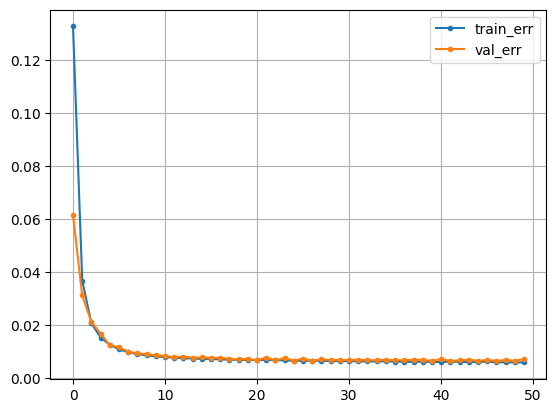

In [16]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [17]:
pred = model1.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

1/1 [==============================] - 0s 87ms/step


## (2) 평가

### 1) 검증성능

In [18]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 10.940848668416342
MAPE: 0.11946406485735642
R2  : 0.00044681536918267373


### 2) 잔차진단

In [ ]:
# train에 대한 잔차 진단.
pred_tr = model1.predict(x_train_s2)

pred_tr = scaler_y.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

19/19 [==============================] - 0s 2ms/step


* 정규성 검정(> 0.05) :  0.60021
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


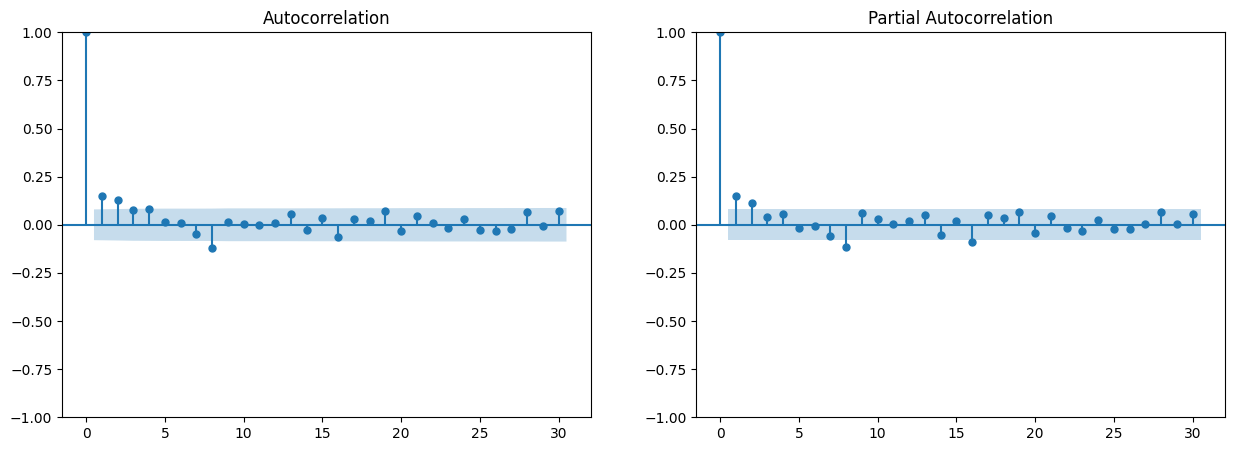

In [ ]:
residual_diag(residuals)

### 3) 결과 시각화

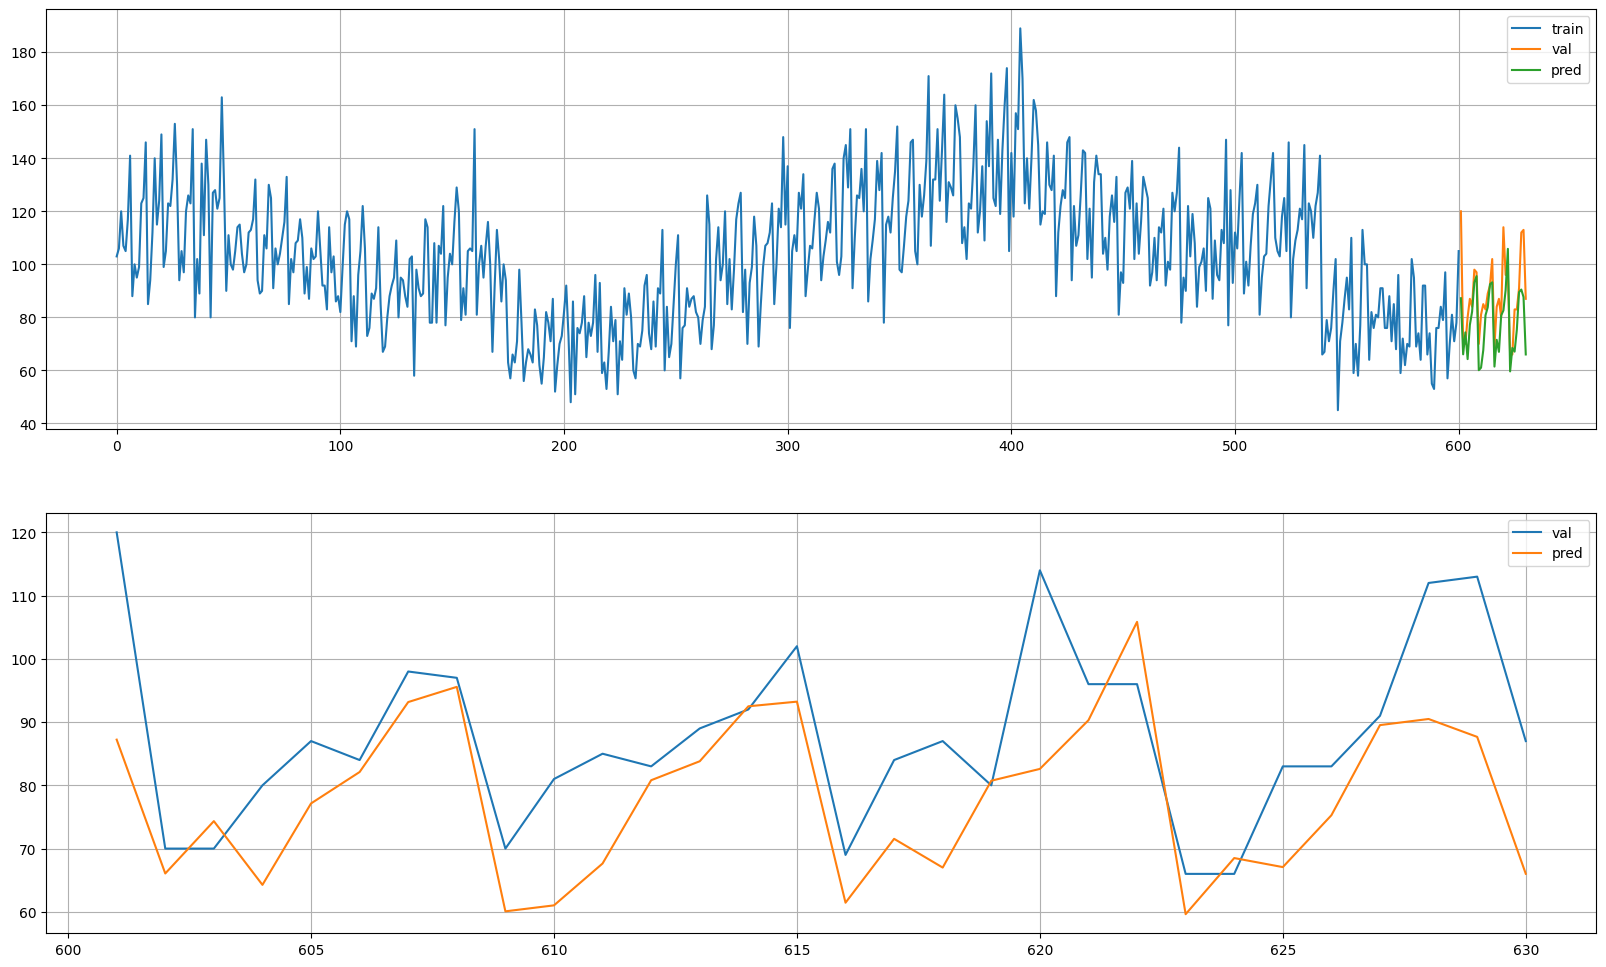

In [19]:
plot_model_result(y_train, y_val, pred)

# 3.모델링2 : DNN

## (1) 학습 및 예측

* 설계

In [24]:
nfeatures = x_train_s2.shape[1]

clear_session()

model2 = Sequential([Dense(32, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1)])

model2.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

* 학습

In [25]:
hist = model2.fit(x_train_s2, y_train_s2, epochs=50, validation_split=.2).history

Epoch 1/50
15/15 [==============================] - 2s 24ms/step - loss: 0.1614 - val_loss: 0.0835
Epoch 2/50
15/15 [==============================] - 0s 6ms/step - loss: 0.1015 - val_loss: 0.0423
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0474 - val_loss: 0.0212
Epoch 4/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0200 - val_loss: 0.0239
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0151 - val_loss: 0.0157
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.0124
Epoch 7/50
15/15 [==============================] - 0s 10ms/step - loss: 0.0098 - val_loss: 0.0100
Epoch 8/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 9/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 10/50
15/15 [==============================] - 0s 8ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 11/50
15/15

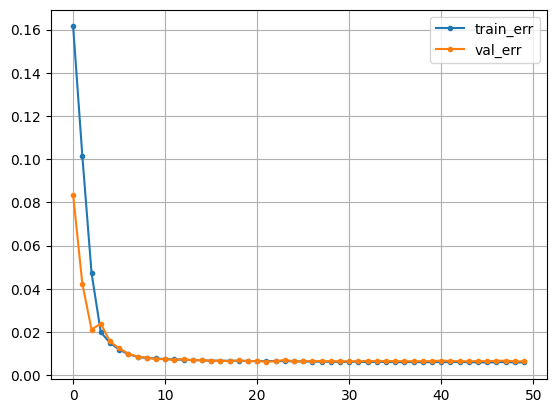

In [26]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

* 예측

In [31]:
pred2 = model2.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred2 = scaler_y.inverse_transform(pred2)
pred2 = pred2.reshape(-1,)

1/1 [==============================] - 0s 20ms/step


## (2) 평가

### 1) 검증성능

In [32]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred2))
print('MAPE:', mean_absolute_percentage_error(y_val, pred2))
print('R2  :', r2_score(y_val, pred2))

MAE : 8.657694753011068
MAPE: 0.09390792712376791
R2  : 0.363842528805591


### 3) 결과 시각화

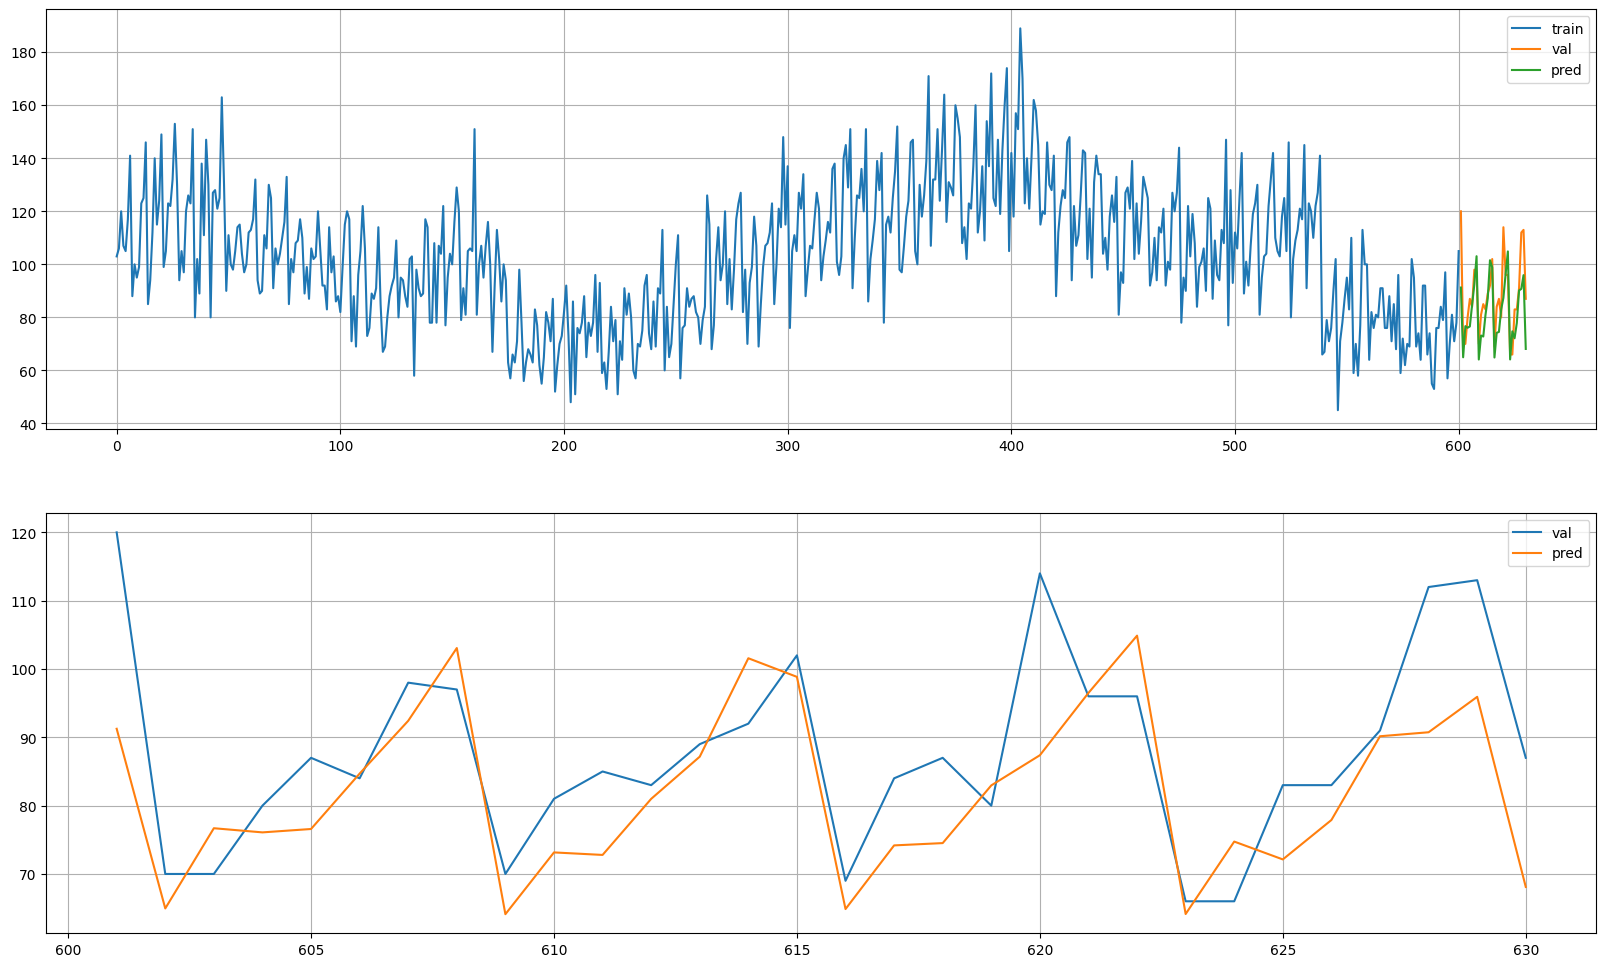

In [33]:
plot_model_result(y_train, y_val, pred2)

# 4.비즈니스 평가

In [45]:
AvgDailyStock, turnover, lost_sum, result_df = inv_simulator(y_val, pred2, 59)

일평균 재고량     : 98.462
일평균 재고회전율 : 0.944
기회손실 수량     : 0.0


In [42]:
AvgDailyStock, turnover, lost_sum, result_df = inv_simulator(y_val, pred, 72)

일평균 재고량     : 108.115
일평균 재고회전율 : 0.871
기회손실 수량     : 0.0


In [21]:
result_df

y   pred  base_stock  close_stock  order  receive  lost
601  120.0   87.0         150           30     74      120   0.0
602   70.0   66.0         100           30     64       70   0.0
603   70.0   74.0         104           34     73       74   0.0
604   80.0   64.0          98           18     94       64   0.0
605   87.0   77.0          91            4    119       73   0.0
606   84.0   82.0          98           14    112       94   0.0
607   98.0   93.0         133           35     55      119   0.0
608   97.0   96.0         147           50     41      112   0.0
609   70.0   60.0         105           35     63       55   0.0
610   81.0   61.0          76            0    111       41  -5.0
611   85.0   68.0          63            0    114       63 -22.0
612   83.0   81.0         111           28     94      111   0.0
613   89.0   84.0         142           53     70      114   0.0
614   92.0   92.0         147           55     36       94   0.0
615  102.0   93.0         125           23     79       70   0.0
616   69.0   61.0          59            0     97       36 -10.0
617   84.0   72.0          79            0    111       79  -5.0
618   87.0   67.0          97           10    103       97   0.0
619   80.0   81.0         121           41     79      111   0.0
620  114.0   83.0         144           30    106      103   0.0
621   96.0   90.0         109           13     77       79   0.0
622   96.0  106.0         119           23     76      106   0.0
623   66.0   60.0         100           34     63       77   0.0
624   66.0   69.0         110           44     61       76   0.0
625   83.0   67.0         107           24     96       63   0.0
626   83.0   75.0          85            2    118       61   0.0
627   91.0   90.0          98            7    111       96   0.0
628  112.0   90.0         125           13     83      118   0.0

# 5.실습
* 22,32,42 번 파일에서 성능이 가장 좋았던 모델을 하나씩 가져다가 다시 생성합니다.
* 각각에 대해 비즈니스 관점에서 평가하고 비교합니다.
    * 기회손실수량은 0 이 되도록, 안전재고 수량을 조절하시오
    * 그때의 일평균재고수량, 재고회전율을 비교하시오.